# Task for the Lab 6:
1. Perform Topic Modeling with LDA for the “articles.csv” dataset – data with the abstracts from the papers of authors associated with ITMO University. Use texts of abstracts as the documents in a corpus.
2. Find the optimal number of topics according to the Perplexity score and/or Coherence score.
How would you name each topic?
3. Visualize your resulting model through pyLDAvis package.

LDA is one the most popular topic modeling algs.

It is based om the Bayes Probabilistic Theory and its theory is quite complex.

Main assumptions:
- every document is a mixture of some number of topics;
- every word (keyyword or token) is connected with some topis with certain probability;
- topics in the document have Dirichlet distribution.

There are two hyperparameters that control document and topic similarity, known as alpha and beta, respectively. A low value of alpha will assign fewer topics to each document whereas a high value of alpha will have the opposite effect. A low value of beta will use fewer words to model a topic whereas a high value will use more words, thus making topics more similar between them.

(https://monkeylearn.com/blog/introduction-to-topic-modeling/#:~:text=Topic%20modeling%20is%20an%20unsupervised,characterize%20a%20set%20of%20documents.)

In [6]:
!pip install pyLDAvis
!pip install gensim

In [22]:
import re
import numpy as np
import pandas as pd
from typing import *
import string

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# LDAvis
import pyLDAvis
import pyLDAvis.gensim  
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import time

from pathlib import Path

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olegtaratuhin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

**Read data**

In [12]:
PATH_TO_DATA = Path("../data/articles.csv")
df = pd.read_csv(PATH_TO_DATA)
data = df.abstract.dropna().values.tolist()

**Preprocessing pipeline**

In [28]:
class PreprocessingPipeline:

    def __init__(self, 
            text: str, 
            custom_stop_words: Optional[List[str]] = None, 
            min_word_size: int = 3):
        self.stop_words = stopwords.words('english')
        if custom_stop_words is None:
            custom_stop_words = []
        self.stop_words.extend(custom_stop_words)
        self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        self.text = text.copy()
        self.min_word_size = min_word_size

    def start(self):
        escaped_punctuation = re.compile('[%s]' % re.escape(string.punctuation))
        escaped_spaces = re.compile(r'\s+')
        escaped_single_quotes = re.compile(r"'")
        latin = re.compile(r'[^a-zA-Z0-9 ]')

        for i in tqdm(range(len(self.text))):
            self.text[i] = escaped_punctuation.sub(' ', self.text[i])
            self.text[i] = latin.sub(' ', self.text[i])
            self.text[i] = escaped_spaces.sub(' ', self.text[i])
            self.text[i] = escaped_single_quotes.sub(' ', self.text[i])
            self.text[i] = ' '.join([word.lower() for word in self.text[i].split() \
                    if len(word) >= self.min_word_size and word not in self.stop_words])
            self.text[i] = self.text[i].strip()
            self.text[i] = gensim.utils.simple_preprocess(str(self.text[i]), deacc=True)
        return self
    
    def init_grams(self, min_count: int = 5, threshold: int = 100):
        print("init_grams started")
        bigram = gensim.models.Phrases(self.text, min_count=min_count, threshold=threshold)
        print("got bigrams")
        trigram = gensim.models.Phrases(bigram[self.text], threshold=threshold)  
        print("got trigrams")
        self.bigram_mod = gensim.models.phrases.Phraser(bigram)
        print("got bigram models")
        self.trigram_mod = gensim.models.phrases.Phraser(trigram)
        print("got trigram models")
        return self

    def make_bigrams(self):
        print("make_bigrams started")
        self.data_words_bigrams =  [self.bigram_mod[doc] for doc in tqdm(self.text)]
        print("make_bigrams finished")
        return self

    def make_trigrams(self):
        print("make_trigrams started")
        self.data_words_trigrams = [self.trigram_mod[self.trigram_mod[doc]] for doc in tqdm(self.text)]
        print("make_trigrams finished")
        return self

    def lemmatize(self, bigrams_or_trigrams=None, allowed_postags=None):
        print("lemmatize started")
        if bigrams_or_trigrams is None:
            bigrams_or_trigrams = self.data_words_bigrams
        if allowed_postags is None:
            allowed_postags = {'NOUN', 'ADJ', 'VERB', 'ADV'}
        texts_out = []
        print("apply spaCy nlp")
        for sent in tqdm(self.text):
            doc = self.nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        print("finished")
        return texts_out

**Get lemmatized words**

In [31]:
start = time.time()

preprocessing_pipeline = PreprocessingPipeline(text=data)
preprocessed_data = preprocessing_pipeline.start().init_grams().make_bigrams().lemmatize()

end = time.time()
print("Processing took", int(end - start), "s")

100%|██████████| 26927/26927 [00:14<00:00, 1883.03it/s]
init_grams started
got bigrams
got trigrams
got bigram models
  4%|▍         | 1202/26927 [00:00<00:04, 5895.10it/s]got trigram models
make_bigrams started
100%|██████████| 26927/26927 [00:05<00:00, 5100.22it/s]
make_bigrams finished
Processing took 163 s


**LDA pipeline**

In [33]:
class LdaModel:

    def __init__(self, data_lemmatized):
        self.start = time.time()
        self.data = data_lemmatized
        self.best_lda_model = None
        self.lda_model = None

    def create_dictionary(self):
        print("create_dictionary started")
        self.id2word = corpora.Dictionary(self.data)
        print('create_dictionary finished')
        return self

    def term_document_freq(self):
        print("term_document_frequency started")
        self.corpus = [self.id2word.doc2bow(text) for text in tqdm(self.data)]
        print('term_document_frequency finished')
        return self

    def build_model(self, num_topics=10):
        print("build_model started")
        start = time.time()
        self.lda_model = gensim.models.ldamodel.LdaModel(
            corpus=self.corpus,
            id2word=self.id2word,
            num_topics=num_topics, 
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=15,
            alpha='auto',
            per_word_topics=True
        )
        finish = time.time()
        print("build_model finished in", int(finish - start), 's')
        return self

    def compute_perplexity(self):
        print("compute_perplexity started")
        if self.best_lda_model:
            self.perplexity = self.best_lda_model.log_perplexity(self.corpus)
        else:
            self.perplexity = self.lda_model.log_perplexity(self.corpus)
        print("compute_perplexity finished")
        return self

    def compute_coherence(self):
        print("compute_coherence started")
        if self.best_lda_model:
            self.coherence = CoherenceModel(
                model=self.best_lda_model,
                texts=self.data,
                dictionary=self.id2word,
                coherence='c_v'
            ).get_coherence()
        else:
            self.coherence = CoherenceModel(
                model=self.lda_model,
                texts=self.data,
                dictionary=self.id2word,
                coherence='c_v'
            ).get_coherence()
        print("compute_coherence finished")
        return self

    def visualize_topics(self):
        pyLDAvis.enable_notebook()
        if self.best_lda_model:
            return pyLDAvis.gensim.prepare(
                self.best_lda_model, 
                self.corpus, 
                self.id2word
            )
        else:
            return pyLDAvis.gensim.prepare(
                self.lda_model, 
                self.corpus, 
                self.id2word
            )

    def find_optimal_num_topics(self, start=2, limit=10, step=2):
        coherence_values = []
        self.best_coherence_score = None
        for num_topics in tqdm(range(start, limit, step)):
            model = gensim.models.ldamodel.LdaModel(
                corpus=self.corpus,
                id2word=self.id2word,
                num_topics=num_topics, 
                random_state=30,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True
            )
            coherencemodel = CoherenceModel(
                model=model, 
                texts=self.data, 
                dictionary=self.id2word, 
                coherence='c_v'
            )
            coherence = coherencemodel.get_coherence()
            coherence_values.append(coherence)
            if self.best_coherence_score is None:
                self.best_coherence_score = coherence
                self.best_lda_model = model
            elif coherence > self.best_coherence_score:
                self.best_coherence_score = coherence
                self.best_lda_model = model

        x_axis_values = range(start, limit, step)
        fig, ax = plt.subplots(figsize=(10,10))
        ax.plot(x_axis_values, coherence_values)
        ax.set_xlabel("Num Topics")
        ax.set_ylabel("Coherence score")
        ax.legend(("coherence_values"), loc='best')
        return self

**Create dictionary and compute tfidf**

In [35]:
lda_model = LdaModel(preprocessed_data).create_dictionary().term_document_freq()
lda_model

create_dictionary started
 17%|█▋        | 4688/26927 [00:00<00:00, 23411.47it/s]create_dictionary finished
term_document_frequency started
100%|██████████| 26927/26927 [00:01<00:00, 23274.93it/s]term_document_frequency finished



**Build LDA model**

In [36]:
lda_model = lda_model.build_model()

build_model started
build_model finished in 197 s


**Compute perplexity**

In [37]:
lda_model\
    .compute_perplexity()
print("Perplexity", lda_model.perplexity)

compute_perplexity started
compute_perplexity finished
Perplexity -8.090475399758281


**Compute coherence**

In [38]:
lda_model\
    .compute_coherence()
print("Coherence", lda_model.coherence)

compute_coherence started
compute_coherence finished
Coherence 0.415033129111441


**Determine optimal topic count**

100%|██████████| 8/8 [17:03<00:00, 127.90s/it]


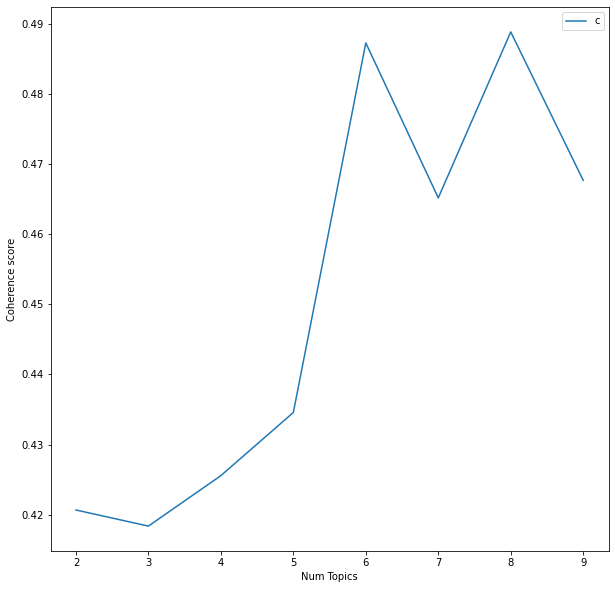

In [39]:
lda_model.find_optimal_num_topics(start=2, limit=10, step=1)

Seems like both 6 topics and 8 topics have high scores, we will choose between them after visualization

**Visualize 8 topics**

In [41]:
lda_model.visualize_topics()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.070683 -0.056446       1        1  21.304434
5      0.094793 -0.051162       2        1  17.201977
3     -0.182227 -0.169130       3        1  14.391366
0     -0.250111 -0.059690       4        1  13.683559
1      0.225376 -0.173824       5        1  11.399235
6      0.238241  0.064060       6        1   9.176142
4     -0.203031  0.075466       7        1   7.007884
7      0.006276  0.370726       8        1   5.835404, topic_info=          Term          Freq         Total Category  logprob  loglift
56      system  15167.000000  15167.000000  Default  30.0000  30.0000
174     method  10080.000000  10080.000000  Default  29.0000  29.0000
218      laser   7005.000000   7005.000000  Default  28.0000  28.0000
334    problem   5506.000000   5506.000000  Default  27.0000  27.0000
523      field   6268.000000   6268.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
506       test    628.550964   1912.749023   Topic8  -5.0599   1.7283
910   increase    699.325867   5492.208496   Topic8  -4.9532   0.7803
2262  language    491.996979    996.736694   Topic8  -5.3049   2.1352
166    include    486.331604   2534.331543   Topic8  -5.3165   1.1904
86      factor    458.512573   1858.222900   Topic8  -5.3754   1.4418

[460 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2259      2  0.999527  abstract
135       6  0.998473    access
553       1  0.962555   account
553       3  0.036799   account
515       1  0.999721  accuracy
...     ...       ...       ...
206       1  0.337070      work
206       2  0.541284      work
206       6  0.121542      work
208       1  0.164978      year
208       6  0.834264      year

[682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 4, 1, 2, 7, 5, 8])

Although 8 topics gives better score two topics are very related and it is difficult to set them apart

**Visualize 6 topics**

In [43]:
lda_model = lda_model.build_model(num_topics=6)
lda_model.best_lda_model = lda_model.lda_model

build_model started
build_model finished in 179 s


In [44]:
lda_model.visualize_topics()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.096093 -0.066707       1        1  27.707512
2      0.010815  0.186543       2        1  25.930870
1     -0.086627  0.159503       3        1  19.654837
0      0.075095 -0.322755       4        1  11.418899
4     -0.239932 -0.026025       5        1   8.412325
3      0.336741  0.069439       6        1   6.875562, topic_info=          Term          Freq         Total Category  logprob  loglift
56      system  13939.000000  13939.000000  Default  30.0000  30.0000
218      laser   7101.000000   7101.000000  Default  29.0000  29.0000
222    optical   6470.000000   6470.000000  Default  28.0000  28.0000
174     method   9333.000000   9333.000000  Default  27.0000  27.0000
132        use  18414.000000  18414.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1571  specific    561.692139   1374.986816   Topic6  -5.3364   1.7820
208       year    503.488708    969.816528   Topic6  -5.4458   2.0217
2989   russian    482.608978    901.639465   Topic6  -5.4882   2.0522
563     effect    643.978210   4373.541016   Topic6  -5.1997   0.7615
120     result    585.010071  10873.313477   Topic6  -5.2958  -0.2452

[353 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
135       4  0.998719    access
515       4  0.999499  accuracy
472       1  0.243958   achieve
472       2  0.013940   achieve
472       3  0.604359   achieve
...     ...       ...       ...
206       3  0.009545      work
206       4  0.012932      work
208       1  0.188695      year
208       4  0.291808      year
208       6  0.518655      year

[555 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 1, 5, 4])

There are two overlapping topics, but they are distingushable, overall it seems to be more reasonable than with 8 topics

**Topic naming**

Topics could be named as:

1. Systematic approach to problem solving
2. Material physics
3. Optics and electomagnetism
4. Information technology
5. Mathematical modeling
6. Bioinformatics